# Identifying signal components across multiple scales of network topology

This demo shows you how to use methods in `graspologic` to analyze patterns
in brain connectivity in connectomics datasets. We specifically demonstrate
methods for identifying differences in edges and vertices across subjects. 

This notebook replicates Figure 4 of _Multiscale Comparative Connectomics_.

<img src="figures/4_signal_tractograms.jpg" alt="Fig4" width="450"/>
<!-- ![Fig4](figures/4_signal_tractograms.jpg) -->

Note that tractograms are not produced in this notebook.
Tractograms of various signal components were made using DSI Studio.
Tracking parameters used in DSI Studio are available in `supplement/tracking_parameters`
and the necessary MRI data can be requested from Dr. G. Allan Johnson.

In [1]:
%load_ext nb_black
%load_ext rpy2.ipython

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.datasets import load_mice
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

pd.options.mode.chained_assignment = None

<IPython.core.display.Javascript object>

## Load the Duke mouse brain dataset

Dataset of 32 mouse connectomes derived from whole-brain diffusion
magnetic resonance imaging of four distinct mouse genotypes:
BTBR T+ Itpr3tf/J (BTBR), C57BL/6J(B6), CAST/EiJ (CAST), and DBA/2J (DBA2).
For each strain, connectomes were generated from eight age-matched mice
(N = 8 per strain), with a sex distribution of four males and four females.
Each connectome was parcellated using asymmetric Waxholm Space, yielding a
vertex set with a total of 332 regions of interest (ROIs) symmetrically
distributed across the left and right hemispheres. Within a given
hemisphere, there are seven superstructures consisting up multiple ROIs,
resulting in a total of 14 distinct communities in each connectome.

In [3]:
ventricles = [147, 151, 160]
ventricles += [roi + 166 for roi in ventricles]
ventricles = np.array(ventricles)

def mask_rois(graphs, rois=ventricles):
    """Remove all connections to and from specified ROIs."""
    graphs = np.delete(graphs, rois, axis=1)
    graphs = np.delete(graphs, rois, axis=2)
    return graphs

<IPython.core.display.Javascript object>

In [4]:
# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)

# Sort the connectomes and genotype labels so BTBR is first
label_indices = np.argsort(mice.labels).reshape(4, 8)
label_indices = label_indices[[1, 0, 2, 3]].reshape(-1)
labels = mice.labels[label_indices]
graphs = graphs[label_indices]
graphs = mask_rois(graphs)
print(graphs.shape)

# Get sample parameters
n_subjects = mice.meta["n_subjects"]
n_vertices = mice.meta["n_vertices"] - 6

(32, 326, 326)


<IPython.core.display.Javascript object>

## Identifying Signal Edges

The simplest approach for comparing connectomes is to treat them as a _bag of edges_ without considering interactions between the edges.
Serially performing univariate statistical analyses at each edge enables the discovery of _signal edges_ whose neurological connectivity differs across categorical or dimensional phenotypes.
Here, we demonstrate the possibility of using Distance Correlation (`Dcorr`), a nonparametric universally consistent test, to detect changes in edges.

In this model, we assume that each edge in the connectome is independently and
identically sampled from some distribution $F_i$, where $i$ represents the group
to which the given connectome belongs. In this setting the groups are the mouse
genotypes. `Dcorr` allows us to test the following hypothesis:

\begin{align*}
H_0:\ &F_1 = F_2 = \cdots = F_k \\
H_A:\ &\exists \ j \neq j' \text{ s.t. } F_j \neq F_{j'}
\end{align*}

In [5]:
from hyppo.ksample import KSample

<IPython.core.display.Javascript object>

In [6]:
# Split the set of graphs by genotype
btbr = graphs[labels == "BTBR"]
b6 = graphs[labels == "B6"]
cast = graphs[labels == "CAST"]
dba2 = graphs[labels == "DBA2"]

connectomes = [btbr, b6, cast, dba2]

<IPython.core.display.Javascript object>

Since the connectomes in this dataset are undirected, we only need to do edge
comparisons on the upper triangle of the adjacency matrices.

In [7]:
# Make iterator for traversing the upper triangle of the connectome
edges_ = np.triu_indices(n_vertices, 1)
indices = zip(*edges_)
n_tests = len(edges_[0])

<IPython.core.display.Javascript object>

In [8]:
edge_pvals = []

for roi_i, roi_j in tqdm(indices, total=n_tests):

    # Get the (i,j)-th edge for each connectome
    samples = [genotype[:, roi_i, roi_j] for genotype in connectomes]

    # Calculate the p-value for the (i,j)-th edge
    try:
        statistic, pvalue = KSample("Dcorr").test(*samples)
    except ValueError:
        # A ValueError is thrown when any of the samples have equal edge
        # weights (i.e. one of the inputs has 0 variance)
        statistic = np.nan
        pvalue = 1

    edge_pvals.append([roi_i + 1, roi_j + 1, statistic, pvalue])

100%|██████████| 52975/52975 [00:10<00:00, 4877.85it/s]


<IPython.core.display.Javascript object>

### Correcting for multiple comparisons

Connectomes are a high-dimensional dataype.
Thus, statistical tests on components of the connectome (e.g., edge, vertices, and communities)
results in multiple comparisons.
We recommend correcting for multiple comparisons using a modified version of the Benjamini-Hochberg procedure.

#### Benjamini-Hochberg Correction

The Benjamini-Hochberg procedure controls the FDR (false discovery rate), i.e., the proportion of rejected null hypotheses (discoveries) that are actually false.
The canonical verison of the procedure assumes that the p-values being corrected are independent of each other.
However, in connectomics data, that assumption is invalid as different structures are interconnected and, therefore, inherently depend on each other.
A correction to the Benjamini-Hochberg procedure that makes it more conservative removes this assumption by allowing the p-values to have any arbitrary dependence structure.

Specifically, for the Benjamini-Hochberg procedure to be valid for connectomics data, the desired FDR (i.e., $\alpha \in [0, 1]$) must be divided by $\sum_{i=1}^m 1/i$ where $m$ is the number of p-values being corrected.

#### Bonferroni-Holm Correction

We also include corrected p-values for a FWER (family-wise error rate) controlling procedure, the Bonferroni-Holm correction.

In [9]:
# Convert the nested list to a dataframe
signal_edges = pd.DataFrame(edge_pvals, columns=["ROI_1", "ROI_2", "stat", "pvalue"])
signal_edges.sort_values(by="pvalue", inplace=True, ignore_index=True)
alpha = 0.05

# Holm-Bonferroni correct p-values
_, holm_pvalue, _, _ = multipletests(signal_edges["pvalue"], alpha=alpha, method="holm")
signal_edges["holm_pvalue"] = holm_pvalue

# Benjamini-Hochberg correct p-values
m = len(signal_edges)
correction = sum((1 / i for i in range(1, m + 1)))
reject, _, _, _ = multipletests(signal_edges["pvalue"], alpha=alpha / correction, method="fdr_bh", is_sorted=True)
signal_edges["bh_significant"] = reject

signal_edges.sort_values(by="pvalue", inplace=True, ignore_index=True)
signal_edges.to_csv("../results/signal_edges.csv", index=False)
signal_edges.head()

,ROI_1,ROI_2,stat,pvalue,holm_pvalue,bh_significant
0,121,227,0.717036,9.911903e-07,0.052508,True
1,121,290,0.699473,1.327371e-06,0.070316,True
2,121,241,0.698197,1.355858e-06,0.071824,True
3,121,240,0.685735,1.668308e-06,0.088374,True
4,225,284,0.670809,2.139082e-06,0.113309,True


<IPython.core.display.Javascript object>

In [10]:
def lookup_roi_name(roi):
    roi += np.sum(roi >= ventricles) # Adjust for removing the ventricles
    roi -= 1
    hemisphere = "R" if roi // 166 else "L"
    roi = roi % 166
    structure = mice.atlas["Structure"].values[roi]
    structure = " ".join(structure.split("_"))
    return f"{structure} ({hemisphere})"

<IPython.core.display.Javascript object>

In [11]:
# Get the top 20 strongest signal edges
strong_signal_edges = signal_edges.head(20)
strong_signal_edges["ROI_1"] = strong_signal_edges["ROI_1"].apply(lookup_roi_name)
strong_signal_edges["ROI_2"] = strong_signal_edges["ROI_2"].apply(lookup_roi_name)
strong_signal_edges

,ROI_1,ROI_2,stat,pvalue,holm_pvalue,bh_significant
0,Corpus Callosum (L),Striatum (R),0.717036,9.911903e-07,0.052508,True
1,Corpus Callosum (L),Internal Capsule (R),0.699473,1.327371e-06,0.070316,True
2,Corpus Callosum (L),Reticular Nucleus of Thalamus (R),0.698197,1.355858e-06,0.071824,True
3,Corpus Callosum (L),Zona Incerta (R),0.685735,1.668308e-06,0.088374,True
4,Septum (R),Corpus Callosum (R),0.670809,2.139082e-06,0.113309,True
5,Striatum (L),Striatum (R),0.663875,2.401064e-06,0.127184,True
6,Corpus Callosum (L),Ventral Thalamic Nuclei (R),0.663380,2.420987e-06,0.128237,True
7,Hippocampus (L),Middle Cerebellar Peduncle (L),0.658415,2.629842e-06,0.139297,True
8,Caudomedial Entorhinal Cortex (R),Ventral Hippocampal Commissure (R),0.655984,2.738604e-06,0.145056,True
9,Corpus Callosum (L),Midbrain Reticular Nucleus (R),0.652512,2.901853e-06,0.153700,True


<IPython.core.display.Javascript object>

In [12]:
# How many p-value corrected edges are significant?
signal_edges["bh_significant"].sum()

5179

<IPython.core.display.Javascript object>

Plot the distribution of edgeweights for the top signal edge across all genotypes.
Clearly different!

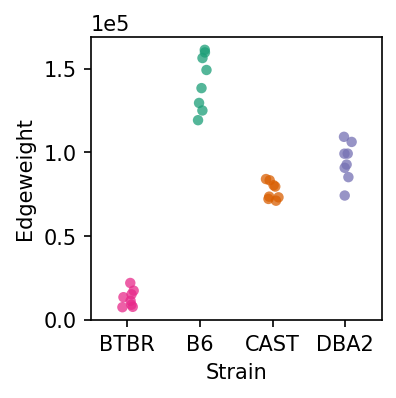

<IPython.core.display.Javascript object>

In [13]:
def stripplot(df, data_column):

    kwargs = {
        "alpha": 0.75,
        "edgecolor": None,
        "linewidth": 0,
        "marker": "o",
        "palette": ["#e7298a", "#1b9e77", "#d95f02", "#7570b3"],
    }

    fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)

    g = sns.stripplot(
        x="Strain",
        y=data_column,
        data=df,
        jitter=True,
        orient="v",
        ax=ax,
        **kwargs,
    )

    return g
    

edgeweight = graphs[:, 121 - 1, 227 - 1]
edgeweight = pd.DataFrame({"Edgeweight": edgeweight, "Strain": labels})
g = stripplot(edgeweight, "Edgeweight")
g.ticklabel_format(style="sci", scilimits=(0, 0), axis="y")
plt.show()

## Identifying Signal Vertices

A sample of connectomes can be jointly embedded in a low-dimensional Euclidean space using the omnibus embedding (`omni`).
A host of machine learning tasks can be accomplished with this joint embedded representation of the connectome, such as clustering or classification of vertices.
Here, we use the embedding to formulate a statistical test that can be used to identify vertices that are strongly associated with given phenotypes.
According to a Central Limit Theorem for `omni`, these latent positions are universally consistent and asymptotically normal.

In [14]:
from itertools import product

from graspologic.embed import OmnibusEmbed

<IPython.core.display.Javascript object>

In [15]:
# Jointly embed graphs using OMNI
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(graphs)
omni_embedding = omni_embedding.reshape(-1, embedder.n_components_)
print(f"Omnibus embedding shape is {omni_embedding.shape}")

# Convert array to a dataframe
omni_embedding = pd.DataFrame(omni_embedding, columns=[f"omni_{i + 1}" for i in range(embedder.n_components_)]).astype(np.float64)
omni_embedding.head()

Omnibus embedding shape is (10432, 5)


,omni_1,omni_2,omni_3,omni_4,omni_5
0,15.661184,-4.884497,5.237723,21.634930,3.793096
1,10.487819,-3.178093,-0.489620,18.743634,0.101909
2,3.318623,-2.310029,-5.885230,10.273286,-1.615462
3,0.895805,-0.755028,-2.435315,3.625679,-0.737963
4,14.854647,-2.753113,1.715284,19.959635,0.375624


<IPython.core.display.Javascript object>

In [16]:
# Construct identifiers for each embedded vertex
rois = np.arange(n_vertices) + 1

participants = mice.participants["participant_id"]
participants = participants.apply(lambda x: x.split("-")[1])

identifiers = np.array(list(product(participants, rois))).reshape(-1, 2)
identifiers = pd.DataFrame(identifiers, columns=["participant_id", "ROI"])
identifiers["ROI"] = identifiers["ROI"].astype(np.int64)
identifiers["genotype"] = np.array([[strain] * n_vertices for strain in labels]).reshape(-1)

omni = pd.concat([omni_embedding, identifiers], axis=1)
omni.head()

,omni_1,omni_2,omni_3,omni_4,omni_5,participant_id,ROI,genotype
0,15.661184,-4.884497,5.237723,21.634930,3.793096,54776,1,BTBR
1,10.487819,-3.178093,-0.489620,18.743634,0.101909,54776,2,BTBR
2,3.318623,-2.310029,-5.885230,10.273286,-1.615462,54776,3,BTBR
3,0.895805,-0.755028,-2.435315,3.625679,-0.737963,54776,4,BTBR
4,14.854647,-2.753113,1.715284,19.959635,0.375624,54776,5,BTBR


<IPython.core.display.Javascript object>

For each of the 32 mice, `omni` embeds each vertex in the connectome as a latent position vector $x \in \mathbb{R}^5$.
We test for differences in the distribution of vertex latent positions using the `R` implementation of `MANOVA`.

In [17]:
%%R -i omni -i n_vertices -o signal_vertices

suppressPackageStartupMessages(require(tidyverse))

col1 <- which(grepl("omni", names(omni))) # column indices for the embeddings
col2 <- which(grepl("genotype", names(omni))) # column index for the genotype

embedding <- colnames(omni)[col1]
genotype <- colnames(omni)[col2]
form <- paste0("cbind(", paste(embedding, collapse=", "), ") ~ ", genotype)

pvec <- rep(0, n_vertices)
pillai <- rep(0, n_vertices)
F <- rep(0, n_vertices)
num.df <- rep(0, n_vertices)
den.df <- rep(0, n_vertices)

for (i in 1 : n_vertices) {
    omni.v <- omni[which(omni$ROI == i), ]
    ans <- manova(as.formula(form), data=omni.v)
    pvec[i] <- summary(ans)$stats[1, "Pr(>F)"]
    pillai[i] <- summary(ans)$stats[1, "Pillai"]
    F[i] <- summary(ans)$stats[1, "approx F"]
    num.df[i] <- summary(ans)$stats[1, "num Df"]
    den.df[i] <- summary(ans)$stats[1, "den Df"]
}

signal_vertices <- data.frame(ROI=unique(omni$ROI), pillai=pillai, F=F, num.df=num.df, den.df=den.df, pvalue=pvec)

<IPython.core.display.Javascript object>

In [18]:
# Correct p-values
signal_vertices.sort_values(by="pvalue", inplace=True, ignore_index=True)
_, holm_pvalue, _, _ = multipletests(signal_vertices["pvalue"], alpha=0.05, method="holm")
signal_vertices["holm_pvalue"] = holm_pvalue

# Benjamini-Hochberg correct p-values
m = len(signal_vertices)
correction = sum((1 / i for i in range(1, m + 1)))
reject, _, _, _ = multipletests(signal_vertices["pvalue"], alpha=alpha / correction, method="fdr_bh", is_sorted=True)
signal_vertices["bh_significant"] = reject

signal_edges.sort_values(by="pvalue", inplace=True, ignore_index=True)
signal_vertices.to_csv("../results/signal_vertices.csv", index=False)

<IPython.core.display.Javascript object>

In [19]:
# Get the top 10 strongest signal edges
strong_signal_vertices = signal_vertices.head(10)
strong_signal_vertices["ROI"] = strong_signal_vertices["ROI"].apply(lookup_roi_name)
strong_signal_vertices

,ROI,pillai,F,num.df,den.df,pvalue,holm_pvalue,bh_significant
0,Corpus Callosum (L),2.591900,33.025931,15.0,78.0,1.370546e-27,4.467980e-25,True
1,Corpus Callosum (R),2.550448,29.501176,15.0,78.0,5.386096e-26,1.750481e-23,True
2,Secondary Motor Cortex (L),2.438402,22.577866,15.0,78.0,2.385152e-22,7.727892e-20,True
3,Midbrain Reticular Nucleus (R),2.435367,22.428551,15.0,78.0,2.920123e-22,9.431999e-20,True
4,Fimbria (L),2.424394,21.901876,15.0,78.0,6.012408e-22,1.935995e-19,True
5,Substantia Nigra (R),2.298846,17.049028,15.0,78.0,9.455684e-19,3.035275e-16,True
6,Secondary Motor Cortex (R),2.298378,17.034193,15.0,78.0,9.692478e-19,3.101593e-16,True
7,Internal Capsule (R),2.297397,17.003148,15.0,78.0,1.020789e-18,3.256318e-16,True
8,Striatum (L),2.259065,15.854467,15.0,78.0,7.291170e-18,2.318592e-15,True
9,Cerebral Peduncle (R),2.229096,15.035989,15.0,78.0,3.147576e-17,9.977817e-15,True


<IPython.core.display.Javascript object>

The strongest signal vertex is the left hemisphere corpus callosum.
THe corpus callosum is the bridge between the left and right hemispheres of the brain.
In BTBR mice, this connection is absent (see the tractograms above).
We would expect our methods to recover this vertex as highly heterogeneous
across strains. This experiment validates this hypothesis!

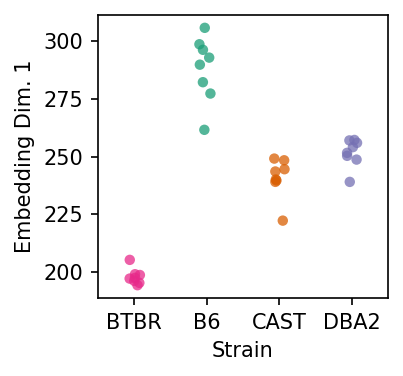

<IPython.core.display.Javascript object>

In [20]:
left_cc = omni.query("ROI == 121")[["omni_1", "genotype"]]
left_cc.columns = ["Embedding Dim. 1", "Strain"]
g = stripplot(left_cc, "Embedding Dim. 1")
plt.show()

## Identifying Signal Communities
Communities are the connections between distinct superstructures in the brain (effectively subgraphs of the connectome).
To test for differences in these subgraphs, we use `DCorr`.

In [21]:
from collections import namedtuple
from itertools import combinations_with_replacement

Point = namedtuple("Point", ["x", "y"])

<IPython.core.display.Javascript object>

In [22]:
def _get_point(community, hemisphere):
    """Make points from database queries."""
    expr = f"block == '{community}' and hemisphere == '{hemisphere}'"
    point = Point(*mice.blocks.query(expr).values[0][2:])
    return point

<IPython.core.display.Javascript object>

In [23]:
def _get_edges(point_1, point_2, sample):
    return sample[:, point_1.x : point_1.y, point_2.x : point_2.y].reshape(8, -1)

<IPython.core.display.Javascript object>

In [24]:
def _get_community_name(block, hemisphere):
    block = " ".join([struct.capitalize() for struct in block.split("_")])
    return f"{block} ({hemisphere})"

<IPython.core.display.Javascript object>

In [25]:
signal_communities = []

for (_, community_1), (_, community_2) in combinations_with_replacement(
    mice.blocks.iterrows(), r=2
):

    point_1 = _get_point(community_1.block, community_1.hemisphere)
    point_2 = _get_point(community_2.block, community_2.hemisphere)

    community_1 = _get_community_name(community_1.block, community_1.hemisphere)
    community_2 = _get_community_name(community_2.block, community_2.hemisphere)

    edges = [_get_edges(point_1, point_2, sample) for sample in connectomes]

    try:
        stat, pvalue = KSample("Dcorr").test(*edges)
    except ValueError as e:
        print(e)
        stat, pvalue = np.nan, 1

    signal_communities.append([community_1, community_2, stat, pvalue])

<IPython.core.display.Javascript object>

In [26]:
signal_communities = pd.DataFrame(
    signal_communities, columns=["Community 1", "Community 2", "statistic", "pvalue"]
)

# Correct p-values
signal_communities = signal_communities.sort_values(["pvalue"])
reject, holm_pvalue, _, _ = multipletests(
    signal_communities["pvalue"], alpha=0.05, method="holm"
)
signal_communities["holm_pvalue"] = holm_pvalue

# Benjamini-Hochberg correct p-values
m = len(signal_communities)
correction = sum((1 / i for i in range(1, m + 1)))
reject, _, _, _ = multipletests(signal_communities["pvalue"], alpha=alpha / correction, method="fdr_bh", is_sorted=True)
signal_communities["bh_significant"] = reject

signal_communities.head()

,Community 1,Community 2,statistic,pvalue,holm_pvalue,bh_significant
104,White Matter (R),White Matter (R),0.885077,6.128165e-08,0.000006,True
69,White Matter (L),White Matter (L),0.856670,9.798217e-08,0.000010,True
61,Hindbrain (L),White Matter (L),0.849136,1.109787e-07,0.000011,True
101,Midbrain (R),White Matter (R),0.844907,1.190169e-07,0.000012,True
0,Isocortex (L),Isocortex (L),0.843782,1.212519e-07,0.000012,True


<IPython.core.display.Javascript object>

In [27]:
signal_communities.to_csv("../results/signal_communities.csv", index=False)

<IPython.core.display.Javascript object>

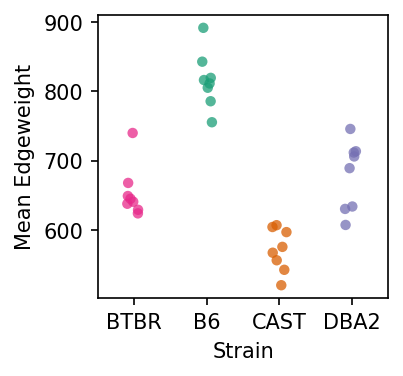

<IPython.core.display.Javascript object>

In [28]:
wm_r = _get_point("white_matter", "R")
wm_r_edgeweight = graphs[:, wm_r.x : wm_r.y, wm_r.x : wm_r.y].reshape(32, -1)
wm_r_mean = wm_r_edgeweight.mean(axis=1)

avg_connectivity = pd.DataFrame({"Mean Edgeweight": wm_r_mean, "Strain": labels})
g = stripplot(avg_connectivity, "Mean Edgeweight")
plt.show()